In [6]:
import numpy as np
import pandas as pd
import pickle
from skimage import io, transform

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

import torch
from torch.optim import lr_scheduler
from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [7]:
from torchvision import models
from torch.optim import lr_scheduler

In [8]:
from PIL import Image

In [9]:
import matplotlib.pyplot as plt

In [10]:
import random
import os
import albumentations as alb

In [11]:
import warnings
warnings.filterwarnings(action='ignore')

# Data processing

In [12]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [13]:
!unzip -q /content/gdrive/My\ Drive/cv2022spring.zip

replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [14]:
torch.cuda.is_available()

True

In [15]:
DEVICE = torch.device('cuda')

In [16]:
!nvidia-smi

Mon Apr 25 16:17:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    27W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [17]:
directory = os.fsencode('/content/train/train/train')
train_names = {}

for file in os.listdir(directory):
  filename = os.fsdecode(file)
  for img in os.listdir('/content/train/train/train/'+filename):
    img_name = os.fsdecode(img)
    train_names.update({'/content/train/train/train/'+filename+'/'+img_name: int(filename[6:])})

In [ ]:
train_names

{'/content/train/train/train/class_064/Image_029.png': 64,
 '/content/train/train/train/class_064/Image_073.png': 64,
 '/content/train/train/train/class_064/Image_001.png': 64,
 '/content/train/train/train/class_064/Image_062.png': 64,
 '/content/train/train/train/class_064/Image_090.png': 64,
 '/content/train/train/train/class_064/Image_044.png': 64,
 '/content/train/train/train/class_064/Image_113.png': 64,
 '/content/train/train/train/class_064/Image_083.png': 64,
 '/content/train/train/train/class_064/Image_013.png': 64,
 '/content/train/train/train/class_064/Image_011.png': 64,
 '/content/train/train/train/class_064/Image_041.png': 64,
 '/content/train/train/train/class_064/Image_096.png': 64,
 '/content/train/train/train/class_064/Image_045.png': 64,
 '/content/train/train/train/class_064/Image_018.png': 64,
 '/content/train/train/train/class_064/Image_026.png': 64,
 '/content/train/train/train/class_064/Image_015.png': 64,
 '/content/train/train/train/class_064/Image_102.png': 6

In [ ]:
len(train_names)

16239

In [18]:
test_names={}
directory1 = os.fsencode('/content/test/test/test')

for file in os.listdir(directory1):
  img_name = os.fsdecode(file)
  #for img in os.listdir('/content/test/test/test/'+filename):
  #img_name = os.fsdecode(img)
  test_names.update({'/content/test/test/test/'+img_name: 0})

In [ ]:
test_names

{'/content/test/test/test/img_2165.png': 0,
 '/content/test/test/test/img_0055.png': 0,
 '/content/test/test/test/img_1836.png': 0,
 '/content/test/test/test/img_0895.png': 0,
 '/content/test/test/test/img_2348.png': 0,
 '/content/test/test/test/img_0327.png': 0,
 '/content/test/test/test/img_2350.png': 0,
 '/content/test/test/test/img_2289.png': 0,
 '/content/test/test/test/img_2173.png': 0,
 '/content/test/test/test/img_1600.png': 0,
 '/content/test/test/test/img_1247.png': 0,
 '/content/test/test/test/img_0210.png': 0,
 '/content/test/test/test/img_0688.png': 0,
 '/content/test/test/test/img_1338.png': 0,
 '/content/test/test/test/img_0764.png': 0,
 '/content/test/test/test/img_0313.png': 0,
 '/content/test/test/test/img_0549.png': 0,
 '/content/test/test/test/img_1529.png': 0,
 '/content/test/test/test/img_1094.png': 0,
 '/content/test/test/test/img_1556.png': 0,
 '/content/test/test/test/img_0426.png': 0,
 '/content/test/test/test/img_2337.png': 0,
 '/content/test/test/test/img_15

In [ ]:
len(test_names)

2500

In [19]:
RESCALE_SIZE = 224

In [20]:
class CVDataSet(Dataset):
  def __init__(self, files, mode='train'):
    self.mode = mode
    #self.trfsm = trsfm

    self.files = files

    if self.mode != 'test':
      self.labels = [int(path.parent.name[6:]) for path in self.files]

    #self.labels = list(files.values()) 
    self.len = len(self.files)

  def __len__(self):
    return len(self.files)

  def load_sample(self, file):
    image = Image.open(file)
    image.load()
    return image

  def __getitem__(self, index):
    # для преобразования изображений в тензоры PyTorch и нормализации входа
    if self.mode == 'train': 
      transform = transforms.Compose([
          transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
          transforms.RandomHorizontalFlip(),
          transforms.ColorJitter(hue=.1, saturation=.1),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
      ])
    else:
      transform = transforms.Compose([
          transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
      ])

    x = self.load_sample(self.files[index])
    x = transform(x)

    #print(self.mode)
    if self.mode == 'train':
      return x, self.labels[index]

    if self.mode == 'val':
      return x, self.labels[index]

    if self.mode == 'test':
      return x


In [21]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [22]:
TRAIN_DIR = Path('/content/train/train/train')
TEST_DIR = Path('/content/test/test/test')

train_val_files = list(TRAIN_DIR.rglob('*.png'))
test_files = list(TEST_DIR.rglob('*.png'))

In [23]:
from sklearn.model_selection import train_test_split

train_val_labels = [int(path.parent.name[6:]) for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [24]:
val_dataset = CVDataSet(val_files, mode='val')
    
train_dataset = CVDataSet(train_files, mode='train')

In [25]:
def create_dct_path_labels(train_files, train_labels):
    dct = {}
    for label_i in np.unique(train_labels).tolist():
        dct[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct[label_i].append(path_i)

    return dct

# Создадим словарь в котором ключами будут кдассы, а значениями списки с путями к картинкам.
dct_path_train = create_dct_path_labels(train_files, train_dataset.labels)

# Дополним картинки классов у которых менее 100 картинок, до 100 картинок в классе
for clas in dct_path_train:
    if len(dct_path_train[clas]) < 100:
        print(clas)
        dct_path_train[clas] = dct_path_train[clas] * (100 // len(dct_path_train[clas]))
        dct_path_train[clas].extend(dct_path_train[clas][:100 - len(dct_path_train[clas])])

# Проверим что получилось 
for clas in dct_path_train:
    print(f"{clas}\t{len(dct_path_train[clas])}")

new_train_files = []
for clas in dct_path_train:
    new_train_files.extend(dct_path_train[clas])

val_dataset = CVDataSet(val_files, mode='val')
new_train_dataset = CVDataSet(new_train_files, mode='train')

2
4
5
6
7
12
15
16
17
19
21
22
24
25
28
32
33
34
36
37
38
39
40
41
43
44
45
47
48
51
52
53
55
59
60
61
63
64
68
69
72
73
76
77
78
79
81
85
87
90
91
93
98
100
101
103
104
105
107
110
111
112
115
116
117
118
119
120
121
122
123
0	100
1	123
2	100
3	100
4	100
5	100
6	100
7	100
8	100
9	115
10	101
11	103
12	100
13	109
14	100
15	100
16	100
17	100
18	111
19	100
20	118
21	100
22	100
23	110
24	100
25	100
26	105
27	101
28	100
29	101
30	106
31	100
32	100
33	100
34	100
35	107
36	100
37	100
38	100
39	100
40	100
41	100
42	106
43	100
44	100
45	100
46	104
47	100
48	100
49	104
50	102
51	100
52	100
53	100
54	101
55	100
56	107
57	115
58	121
59	100
60	100
61	100
62	100
63	100
64	100
65	104
66	101
67	117
68	100
69	100
70	106
71	110
72	100
73	100
74	100
75	103
76	100
77	100
78	100
79	100
80	103
81	100
82	100
83	108
84	100
85	100
86	100
87	100
88	100
89	103
90	100
91	100
92	105
93	100
94	109
95	115
96	111
97	115
98	100
99	100
100	100
101	100
102	106
103	100
104	100
105	100
106	109
107	100
108	105
109	102
110	

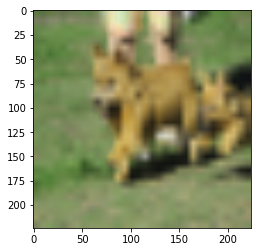

In [26]:
imshow(new_train_dataset[0][0])

In [27]:
def fit_epoch(model, train_loader, criterion, optimizer):
  running_loss = 0.0
  running_corrects = 0
  processed_data = 0

  for inputs, labels in train_loader:
    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)
    optimizer.zero_grad()

    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    preds = torch.argmax(outputs, 1)
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
    processed_data += inputs.size(0)
            
  train_loss = running_loss / processed_data
  train_acc = running_corrects.cpu().numpy() / processed_data
  return train_loss, train_acc

In [28]:
def eval_epoch(model, val_loader, criterion):
  model.eval()
  running_loss = 0.0
  running_corrects = 0
  processed_size = 0

  for inputs, labels in val_loader:
    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)

    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        preds = torch.argmax(outputs, 1)

    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
    processed_size += inputs.size(0)

  val_loss = running_loss / processed_size
  val_acc = running_corrects.double() / processed_size
  return val_loss, val_acc

In [29]:
def train(train_dataset, val_dataset, model, epochs, batch_size, scheduler):
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

  history = []
  log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
  val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

  with tqdm(desc="epoch", total=epochs) as pbar_outer:
    opt = torch.optim.Adam(model.parameters(), lr = 1e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(opt, 3, 0.5)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
      train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
      print("loss", train_loss)

      val_loss, val_acc = eval_epoch(model, val_loader, criterion)
      history.append((train_loss, train_acc, val_loss, val_acc))
      scheduler.step()
      pbar_outer.update(1)
      tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                      v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

  return history

In [30]:
def predict(model, test_loader):
  with torch.no_grad():
    logits = []

    for inputs in test_loader:
      inputs = inputs.to(DEVICE)
      model.eval()
      outputs = model(inputs).cpu()
      logits.append(outputs)

  probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
  return probs

In [31]:
n_classes = len(np.unique(train_val_labels))

In [32]:
n_classes

125

# Model 1

In [ ]:

class SimpleCnn(nn.Module):
  
  def __init__(self, n_classes):
    super(SimpleCnn, self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv4 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv5 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.out = nn.Linear(96 * 5 * 5, n_classes)


  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)

    x = x.view(x.size(0), -1)
    logits = self.out(x)
    return logits

In [ ]:
model = SimpleCnn(n_classes).to(DEVICE)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
history = train(train_dataset, val_dataset, model=model, epochs=10, batch_size=64, scheduler=exp_lr_scheduler)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 4.596078172909704


epoch:  10%|█         | 1/10 [00:59<08:58, 59.89s/it]


Epoch 001 train_loss: 4.5961   val_loss 4.4245 train_acc 0.0341 val_acc 0.0552
loss 4.225732124363694


epoch:  20%|██        | 2/10 [02:00<08:03, 60.43s/it]


Epoch 002 train_loss: 4.2257   val_loss 4.1768 train_acc 0.0856 val_acc 0.0998
loss 3.950524974626923


epoch:  30%|███       | 3/10 [03:00<07:02, 60.36s/it]


Epoch 003 train_loss: 3.9505   val_loss 4.0700 train_acc 0.1271 val_acc 0.1158
loss 3.688925037654968


epoch:  40%|████      | 4/10 [04:01<06:01, 60.28s/it]


Epoch 004 train_loss: 3.6889   val_loss 3.9696 train_acc 0.1617 val_acc 0.1357
loss 3.566039096898991


epoch:  50%|█████     | 5/10 [05:00<04:59, 59.89s/it]


Epoch 005 train_loss: 3.5660   val_loss 3.9368 train_acc 0.1879 val_acc 0.1458
loss 3.462257867572401


epoch:  60%|██████    | 6/10 [05:58<03:57, 59.34s/it]


Epoch 006 train_loss: 3.4623   val_loss 3.9246 train_acc 0.2089 val_acc 0.1500
loss 3.301057895931648


epoch:  70%|███████   | 7/10 [06:56<02:57, 59.02s/it]


Epoch 007 train_loss: 3.3011   val_loss 3.9290 train_acc 0.2346 val_acc 0.1483
loss 3.239486918522617


epoch:  80%|████████  | 8/10 [07:56<01:58, 59.24s/it]


Epoch 008 train_loss: 3.2395   val_loss 3.9336 train_acc 0.2456 val_acc 0.1567
loss 3.1816313298663363


epoch:  90%|█████████ | 9/10 [08:55<00:59, 59.01s/it]


Epoch 009 train_loss: 3.1816   val_loss 3.9477 train_acc 0.2527 val_acc 0.1574
loss 3.094378926051408


epoch: 100%|██████████| 10/10 [09:53<00:00, 59.32s/it]


Epoch 010 train_loss: 3.0944   val_loss 3.9690 train_acc 0.2734 val_acc 0.1608


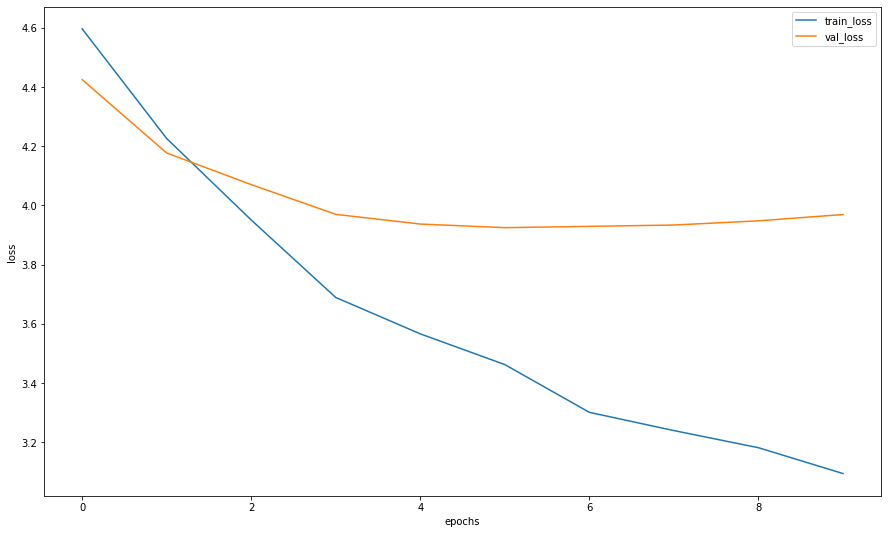

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Kaggle score: 0.00640

In [ ]:
test_dataset = CVDataSet(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=40)
probs = predict(SimpleCnn(n_classes).to(DEVICE), test_loader)

#preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
preds = np.argmax(probs, axis=1)

In [ ]:
import pandas as pd
df = pd.DataFrame()
df['image'] = test_filenames
df['label'] = preds
df.to_csv('gdrive/My Drive/cv2022spring_1.csv', index=False)

In [ ]:
history = train(train_dataset, val_dataset, model=model, epochs=15, batch_size=64, scheduler=exp_lr_scheduler)

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

loss 3.335211655592251


epoch:   7%|▋         | 1/15 [00:58<13:39, 58.55s/it]


Epoch 001 train_loss: 3.3352   val_loss 3.9734 train_acc 0.2246 val_acc 0.1517
loss 3.195474263511568


epoch:  13%|█▎        | 2/15 [01:57<12:43, 58.77s/it]


Epoch 002 train_loss: 3.1955   val_loss 3.9785 train_acc 0.2480 val_acc 0.1525
loss 3.1012639010204097


epoch:  20%|██        | 3/15 [02:56<11:47, 58.96s/it]


Epoch 003 train_loss: 3.1013   val_loss 4.0785 train_acc 0.2632 val_acc 0.1451
loss 2.883585663575513


epoch:  27%|██▋       | 4/15 [03:55<10:47, 58.90s/it]


Epoch 004 train_loss: 2.8836   val_loss 4.1505 train_acc 0.3062 val_acc 0.1564
loss 2.8052327382328652


epoch:  33%|███▎      | 5/15 [04:54<09:48, 58.81s/it]


Epoch 005 train_loss: 2.8052   val_loss 4.0970 train_acc 0.3277 val_acc 0.1645
loss 2.7354890303968435


epoch:  40%|████      | 6/15 [05:52<08:49, 58.83s/it]


Epoch 006 train_loss: 2.7355   val_loss 4.1756 train_acc 0.3392 val_acc 0.1648
loss 2.583142877202559


epoch:  47%|████▋     | 7/15 [06:51<07:50, 58.81s/it]


Epoch 007 train_loss: 2.5831   val_loss 4.2811 train_acc 0.3688 val_acc 0.1621
loss 2.553090471167783


epoch:  53%|█████▎    | 8/15 [07:50<06:52, 58.87s/it]


Epoch 008 train_loss: 2.5531   val_loss 4.2537 train_acc 0.3784 val_acc 0.1599
loss 2.506036382011616


epoch:  60%|██████    | 9/15 [08:49<05:53, 58.87s/it]


Epoch 009 train_loss: 2.5060   val_loss 4.3069 train_acc 0.3874 val_acc 0.1579
loss 2.4234659478957847


epoch:  67%|██████▋   | 10/15 [09:49<04:55, 59.06s/it]


Epoch 010 train_loss: 2.4235   val_loss 4.3934 train_acc 0.4059 val_acc 0.1643
loss 2.4002219030878424


epoch:  73%|███████▎  | 11/15 [10:50<03:59, 59.89s/it]


Epoch 011 train_loss: 2.4002   val_loss 4.4193 train_acc 0.4087 val_acc 0.1628
loss 2.3720878156224576


epoch:  80%|████████  | 12/15 [11:52<03:00, 60.29s/it]


Epoch 012 train_loss: 2.3721   val_loss 4.4772 train_acc 0.4187 val_acc 0.1606
loss 2.3259810308819286


epoch:  87%|████████▋ | 13/15 [12:53<02:01, 60.58s/it]


Epoch 013 train_loss: 2.3260   val_loss 4.5092 train_acc 0.4248 val_acc 0.1608
loss 2.3229324228805277


epoch:  93%|█████████▎| 14/15 [13:54<01:00, 60.73s/it]


Epoch 014 train_loss: 2.3229   val_loss 4.5184 train_acc 0.4284 val_acc 0.1623
loss 2.3094944794763923


epoch: 100%|██████████| 15/15 [14:55<00:00, 59.68s/it]


Epoch 015 train_loss: 2.3095   val_loss 4.5295 train_acc 0.4317 val_acc 0.1635


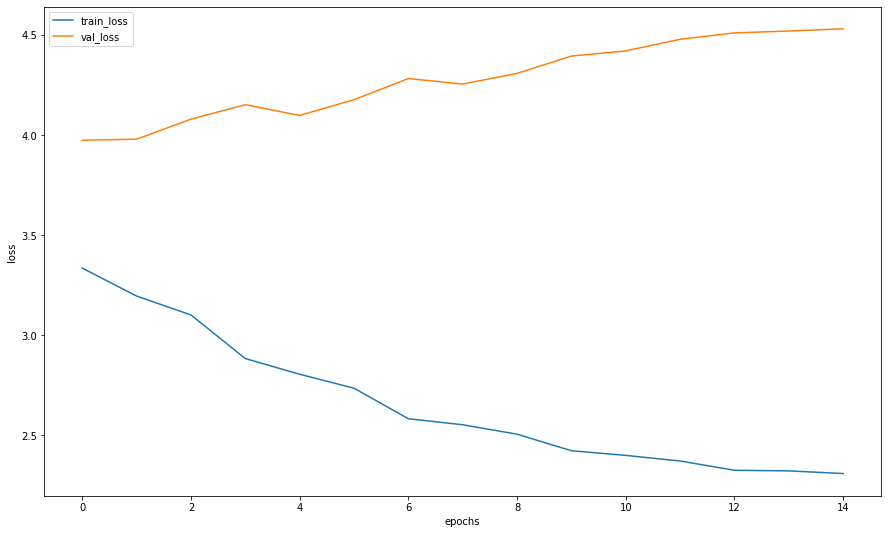

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
test_dataset = CVDataSet(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=40)
probs = predict(SimpleCnn(n_classes).to(DEVICE), test_loader)
test_filenames = [path.name for path in test_dataset.files]
preds = np.argmax(probs, axis=1)

df = pd.DataFrame()
df['image'] = test_filenames
df['label'] = preds
df.to_csv('gdrive/My Drive/cv2022spring_2.csv', index=False)

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

Kagle score: 0.00959

# Model 2

In [ ]:
class Cnn_2(nn.Module):
  
  def __init__(self, n_classes):
    super(Cnn_2, self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
        nn.ReLU(),
        #nn.MaxPool2d(kernel_size=2)
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
        nn.ReLU(),
        #nn.MaxPool2d(kernel_size=2)
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
        nn.ReLU(),
        #nn.MaxPool2d(kernel_size=2)
    )
    self.conv4 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        nn.ReLU(),
        #nn.MaxPool2d(kernel_size=2)
    )
    self.conv5 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
        nn.ReLU(),
        #nn.MaxPool2d(kernel_size=2)
    )

    self.out = nn.Sequential(
        nn.Linear(96 * 22 * 22, 4000),
        nn.ReLU(),
        nn.Linear(4000, 1000),
        nn.ReLU(),
        nn.Linear(1000, n_classes)
        )


  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)

    x = x.view(x.size(0), -1)
    logits = self.out(x)
    return logits

In [ ]:
model = Cnn_2(n_classes).to(DEVICE)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
history = train(train_dataset, val_dataset, model=model, epochs=20, batch_size=64, scheduler=exp_lr_scheduler)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 4.825138515904968


epoch:   5%|▌         | 1/20 [00:54<17:12, 54.36s/it]


Epoch 001 train_loss: 4.8251   val_loss 4.8221 train_acc 0.0101 val_acc 0.0101
loss 4.824406832640116


epoch:  10%|█         | 2/20 [01:48<16:18, 54.34s/it]


Epoch 002 train_loss: 4.8244   val_loss 4.8219 train_acc 0.0095 val_acc 0.0101
loss 4.824168051431426


epoch:  15%|█▌        | 3/20 [02:43<15:23, 54.34s/it]


Epoch 003 train_loss: 4.8242   val_loss 4.8224 train_acc 0.0101 val_acc 0.0101
loss 4.823281058557261


epoch:  20%|██        | 4/20 [03:36<14:25, 54.07s/it]


Epoch 004 train_loss: 4.8233   val_loss 4.8219 train_acc 0.0101 val_acc 0.0101
loss 4.823198456611135


epoch:  25%|██▌       | 5/20 [04:30<13:28, 53.91s/it]


Epoch 005 train_loss: 4.8232   val_loss 4.8217 train_acc 0.0101 val_acc 0.0101
loss 4.8232665896288465


epoch:  30%|███       | 6/20 [05:23<12:33, 53.79s/it]


Epoch 006 train_loss: 4.8233   val_loss 4.8218 train_acc 0.0093 val_acc 0.0101
loss 4.822758025239769


epoch:  35%|███▌      | 7/20 [06:17<11:38, 53.71s/it]


Epoch 007 train_loss: 4.8228   val_loss 4.8218 train_acc 0.0097 val_acc 0.0101
loss 4.822725371584652


epoch:  40%|████      | 8/20 [07:11<10:44, 53.70s/it]


Epoch 008 train_loss: 4.8227   val_loss 4.8217 train_acc 0.0101 val_acc 0.0101
loss 4.82272650034853


epoch:  45%|████▌     | 9/20 [08:04<09:50, 53.68s/it]


Epoch 009 train_loss: 4.8227   val_loss 4.8217 train_acc 0.0101 val_acc 0.0101
loss 4.822493400349779


epoch:  50%|█████     | 10/20 [08:58<08:56, 53.64s/it]


Epoch 010 train_loss: 4.8225   val_loss 4.8217 train_acc 0.0101 val_acc 0.0101
loss 4.822502807224411


epoch:  55%|█████▌    | 11/20 [09:52<08:02, 53.67s/it]


Epoch 011 train_loss: 4.8225   val_loss 4.8217 train_acc 0.0101 val_acc 0.0101
loss 4.822492909300297


epoch:  60%|██████    | 12/20 [10:45<07:09, 53.66s/it]


Epoch 012 train_loss: 4.8225   val_loss 4.8217 train_acc 0.0101 val_acc 0.0101
loss 4.822367502380566


epoch:  65%|██████▌   | 13/20 [11:39<06:16, 53.84s/it]


Epoch 013 train_loss: 4.8224   val_loss 4.8217 train_acc 0.0101 val_acc 0.0101
loss 4.822355162051034


epoch:  70%|███████   | 14/20 [12:33<05:23, 53.87s/it]


Epoch 014 train_loss: 4.8224   val_loss 4.8217 train_acc 0.0101 val_acc 0.0101
loss 4.822365994543089


epoch:  75%|███████▌  | 15/20 [13:31<04:35, 55.01s/it]


Epoch 015 train_loss: 4.8224   val_loss 4.8217 train_acc 0.0101 val_acc 0.0101
loss 4.822304816911232


epoch:  80%|████████  | 16/20 [14:27<03:41, 55.33s/it]


Epoch 016 train_loss: 4.8223   val_loss 4.8217 train_acc 0.0101 val_acc 0.0101
loss 4.822304192430349


epoch:  85%|████████▌ | 17/20 [15:23<02:46, 55.46s/it]


Epoch 017 train_loss: 4.8223   val_loss 4.8217 train_acc 0.0101 val_acc 0.0101
loss 4.822300885853014


epoch:  90%|█████████ | 18/20 [16:19<01:51, 55.56s/it]


Epoch 018 train_loss: 4.8223   val_loss 4.8217 train_acc 0.0101 val_acc 0.0101
loss 4.822269543098771


epoch:  95%|█████████▌| 19/20 [17:14<00:55, 55.40s/it]


Epoch 019 train_loss: 4.8223   val_loss 4.8217 train_acc 0.0101 val_acc 0.0101
loss 4.822266751767105


epoch: 100%|██████████| 20/20 [18:08<00:00, 54.44s/it]


Epoch 020 train_loss: 4.8223   val_loss 4.8217 train_acc 0.0101 val_acc 0.0101


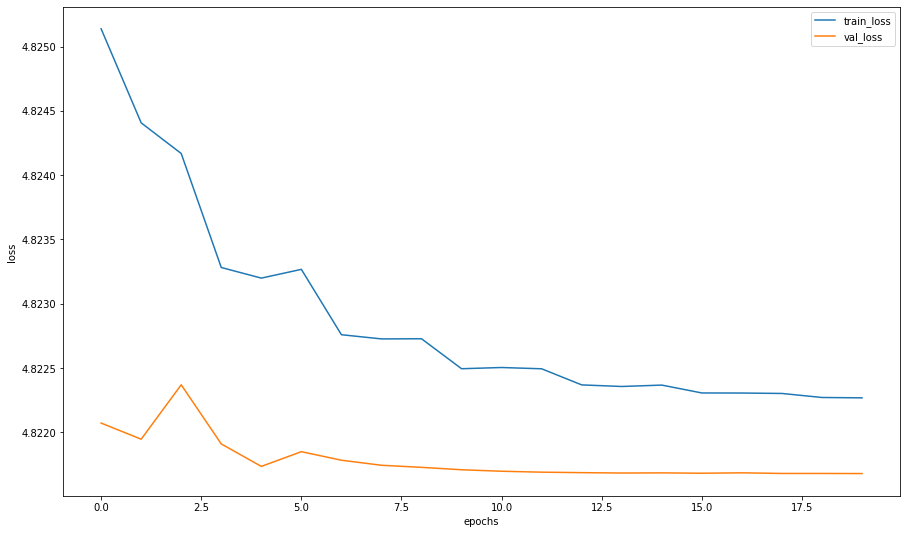

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# Model 3

In [ ]:
class Cnn_3(nn.Module):

  def __init__(self, n_classes):
    super(Cnn_3, self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3)
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3)
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
        nn.ReLU(),
        #nn.MaxPool2d(kernel_size=2)
    )
    self.conv4 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3)
    )
    self.conv5 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=96, kernel_size=2),
        nn.ReLU(),
        #nn.MaxPool2d(kernel_size=2)
    )

    self.out = nn.Sequential(
        nn.Linear(96 * 2 * 2, 4000),
        nn.ReLU(),
        nn.Linear(4000, 1000),
        nn.ReLU(),
        nn.Linear(1000, n_classes)
        )


  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)

    x = x.view(x.size(0), -1)
    logits = self.out(x)
    return logits

In [ ]:
model = Cnn_3(n_classes).to(DEVICE)

In [ ]:
history = train(train_dataset, val_dataset, model=model, epochs=25, batch_size=64, scheduler=exp_lr_scheduler)

epoch:   0%|          | 0/25 [00:00<?, ?it/s]

loss 4.720043170979697


epoch:   4%|▍         | 1/25 [02:48<1:07:11, 167.99s/it]


Epoch 001 train_loss: 4.7200   val_loss 4.6148 train_acc 0.0195 val_acc 0.0266
loss 4.51568676143339


epoch:   8%|▊         | 2/25 [05:33<1:03:55, 166.76s/it]


Epoch 002 train_loss: 4.5157   val_loss 4.4781 train_acc 0.0346 val_acc 0.0384
loss 4.429019060674408


epoch:  12%|█▏        | 3/25 [08:19<1:00:53, 166.08s/it]


Epoch 003 train_loss: 4.4290   val_loss 4.4157 train_acc 0.0425 val_acc 0.0490
loss 4.299037013698734


epoch:  16%|█▌        | 4/25 [11:04<58:03, 165.89s/it]


Epoch 004 train_loss: 4.2990   val_loss 4.2963 train_acc 0.0643 val_acc 0.0640
loss 4.21447292334615


epoch:  20%|██        | 5/25 [13:43<54:28, 163.40s/it]


Epoch 005 train_loss: 4.2145   val_loss 4.2095 train_acc 0.0739 val_acc 0.0820
loss 4.144445014671403


epoch:  24%|██▍       | 6/25 [16:16<50:36, 159.84s/it]


Epoch 006 train_loss: 4.1444   val_loss 4.1910 train_acc 0.0827 val_acc 0.0830
loss 4.030275888166577

Epoch 007 train_loss: 4.0303   val_loss 4.1101 train_acc 0.0957 val_acc 0.0919
loss 3.9730405147385546


epoch:  32%|███▏      | 8/25 [21:15<43:42, 154.24s/it]


Epoch 008 train_loss: 3.9730   val_loss 4.1079 train_acc 0.1042 val_acc 0.0953
loss 3.927872533623598


epoch:  36%|███▌      | 9/25 [23:47<40:54, 153.42s/it]


Epoch 009 train_loss: 3.9279   val_loss 4.0571 train_acc 0.1098 val_acc 0.1064
loss 3.8434069229078682


epoch:  40%|████      | 10/25 [26:15<37:54, 151.64s/it]


Epoch 010 train_loss: 3.8434   val_loss 4.0390 train_acc 0.1255 val_acc 0.1131
loss 3.816788751490354


epoch:  44%|████▍     | 11/25 [28:46<35:19, 151.40s/it]


Epoch 011 train_loss: 3.8168   val_loss 4.0337 train_acc 0.1296 val_acc 0.1133
loss 3.7813113523103183


epoch:  48%|████▊     | 12/25 [31:15<32:38, 150.66s/it]


Epoch 012 train_loss: 3.7813   val_loss 4.0216 train_acc 0.1321 val_acc 0.1121
loss 3.7397556349761145


epoch:  52%|█████▏    | 13/25 [33:44<30:03, 150.30s/it]


Epoch 013 train_loss: 3.7398   val_loss 4.0099 train_acc 0.1419 val_acc 0.1197
loss 3.723620436052372


epoch:  56%|█████▌    | 14/25 [36:15<27:36, 150.59s/it]


Epoch 014 train_loss: 3.7236   val_loss 3.9989 train_acc 0.1454 val_acc 0.1217
loss 3.70574950903681


epoch:  60%|██████    | 15/25 [38:47<25:08, 150.85s/it]


Epoch 015 train_loss: 3.7057   val_loss 4.0163 train_acc 0.1466 val_acc 0.1224
loss 3.689217376830357


epoch:  64%|██████▍   | 16/25 [41:15<22:29, 149.93s/it]


Epoch 016 train_loss: 3.6892   val_loss 4.0093 train_acc 0.1482 val_acc 0.1236
loss 3.672909866991238


epoch:  68%|██████▊   | 17/25 [43:43<19:56, 149.59s/it]


Epoch 017 train_loss: 3.6729   val_loss 4.0014 train_acc 0.1533 val_acc 0.1239
loss 3.664973828463496


epoch:  72%|███████▏  | 18/25 [46:18<17:37, 151.01s/it]


Epoch 018 train_loss: 3.6650   val_loss 4.0066 train_acc 0.1537 val_acc 0.1241
loss 3.653705570828749


epoch:  76%|███████▌  | 19/25 [48:53<15:14, 152.36s/it]


Epoch 019 train_loss: 3.6537   val_loss 4.0001 train_acc 0.1541 val_acc 0.1241
loss 3.6490789610467056


epoch:  80%|████████  | 20/25 [51:29<12:47, 153.44s/it]


Epoch 020 train_loss: 3.6491   val_loss 4.0016 train_acc 0.1557 val_acc 0.1246
loss 3.6462712142451643


epoch:  84%|████████▍ | 21/25 [54:02<10:13, 153.29s/it]


Epoch 021 train_loss: 3.6463   val_loss 3.9973 train_acc 0.1549 val_acc 0.1227
loss 3.6374654881873343


epoch:  88%|████████▊ | 22/25 [56:34<07:38, 152.96s/it]


Epoch 022 train_loss: 3.6375   val_loss 4.0005 train_acc 0.1572 val_acc 0.1239
loss 3.6258781058064566


epoch:  92%|█████████▏| 23/25 [59:09<05:07, 153.50s/it]


Epoch 023 train_loss: 3.6259   val_loss 4.0010 train_acc 0.1590 val_acc 0.1251
loss 3.6293008122717043


epoch:  96%|█████████▌| 24/25 [1:01:54<02:36, 156.88s/it]


Epoch 024 train_loss: 3.6293   val_loss 4.0011 train_acc 0.1609 val_acc 0.1244
loss 3.6314343895189025


epoch: 100%|██████████| 25/25 [1:04:37<00:00, 155.09s/it]


Epoch 025 train_loss: 3.6314   val_loss 4.0005 train_acc 0.1549 val_acc 0.1244


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)
val_acc = [val_acc[i].cpu().numpy() for i in range(len(val_acc))]

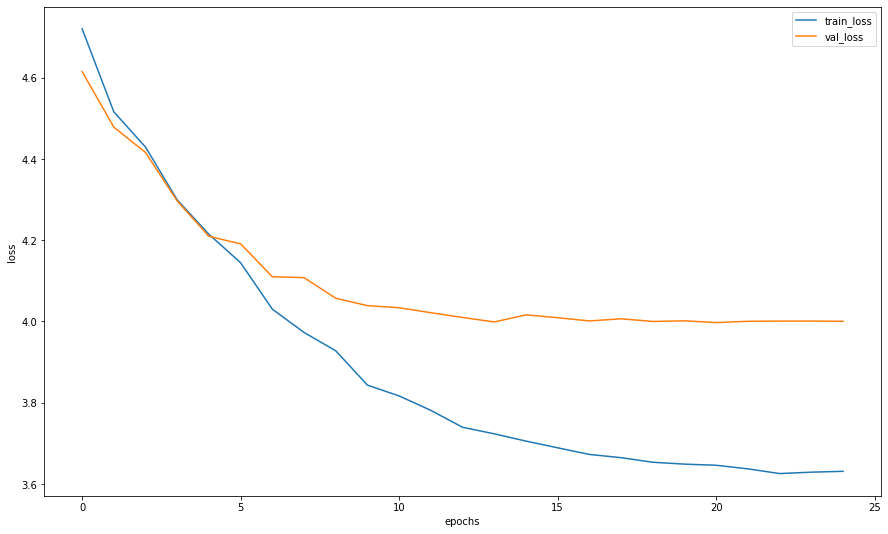

In [ ]:

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

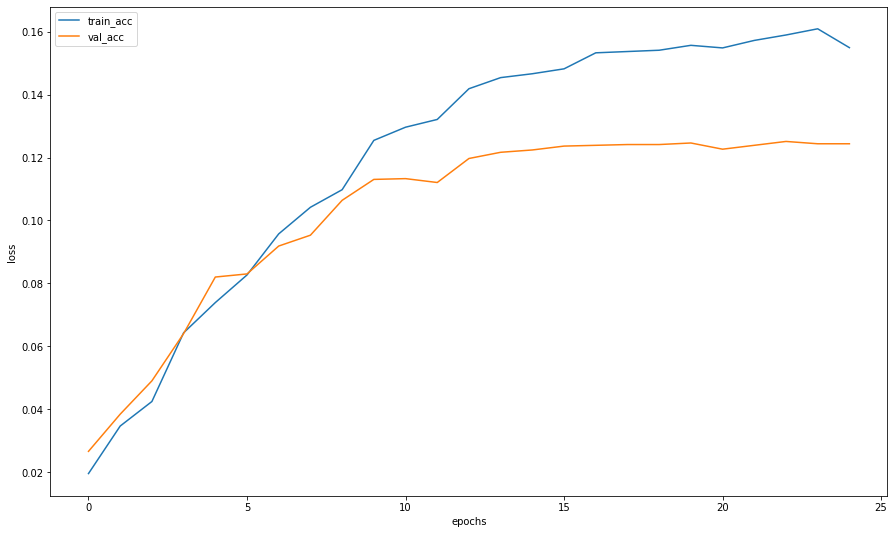

In [ ]:

plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
test_dataset = CVDataSet(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=40)
probs = predict(Cnn_3(n_classes).to(DEVICE), test_loader)
test_filenames = [path.name for path in test_dataset.files]
preds = np.argmax(probs, axis=1)

df = pd.DataFrame()
df['image'] = test_filenames
df['label'] = preds
df.to_csv('gdrive/My Drive/cv2022spring_3.csv', index=False)

Kaggle score: 0.00720

# Model 4 (transfer learning)

In [ ]:
#Обучение AlexNet с уменьшенным learning rate для первых слоев сети
from torchvision import models
from torch.optim import lr_scheduler
alex_dif_lr = models.alexnet(pretrained=False)
num_features = 9216 #количество features поступающих на вход классифатору
alex_dif_lr.classifier = nn.Linear(num_features, n_classes)

optimizer = torch.optim.Adam(params=[{'params': alex_dif_lr.classifier.parameters()},
                                     {'params': alex_dif_lr.features.parameters(), 'lr': 1e-3}],
                             lr = 1e-3 )
criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
alex_dif_lr.to("cuda")

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Linear(in_features=9216, out_features=125, bias=True)
)

In [ ]:
history = train(train_dataset, val_dataset, model=alex_dif_lr, epochs=5, batch_size=64, scheduler=exp_lr_scheduler)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 4.755761523778847


epoch:  20%|██        | 1/5 [02:51<11:26, 171.59s/it]


Epoch 001 train_loss: 4.7558   val_loss 4.6461 train_acc 0.0171 val_acc 0.0303
loss 4.593766889408487


epoch:  40%|████      | 2/5 [05:41<08:30, 170.30s/it]


Epoch 002 train_loss: 4.5938   val_loss 4.5976 train_acc 0.0344 val_acc 0.0456
loss 4.488250939577258


epoch:  60%|██████    | 3/5 [08:29<05:38, 169.32s/it]


Epoch 003 train_loss: 4.4883   val_loss 4.4918 train_acc 0.0475 val_acc 0.0512
loss 4.330037797238305


epoch:  80%|████████  | 4/5 [11:14<02:47, 167.94s/it]


Epoch 004 train_loss: 4.3300   val_loss 4.3934 train_acc 0.0718 val_acc 0.0645
loss 4.205891356110739


epoch: 100%|██████████| 5/5 [14:01<00:00, 168.29s/it]


Epoch 005 train_loss: 4.2059   val_loss 4.3058 train_acc 0.0893 val_acc 0.0783


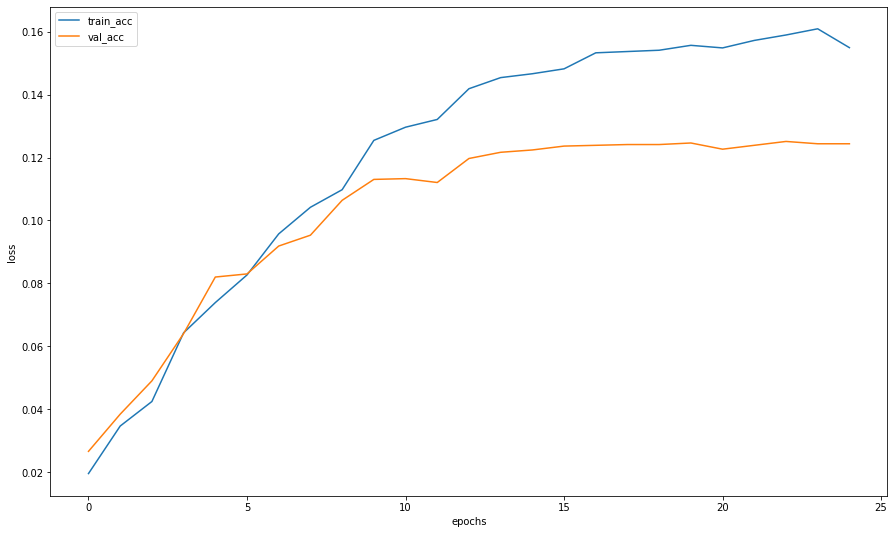

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

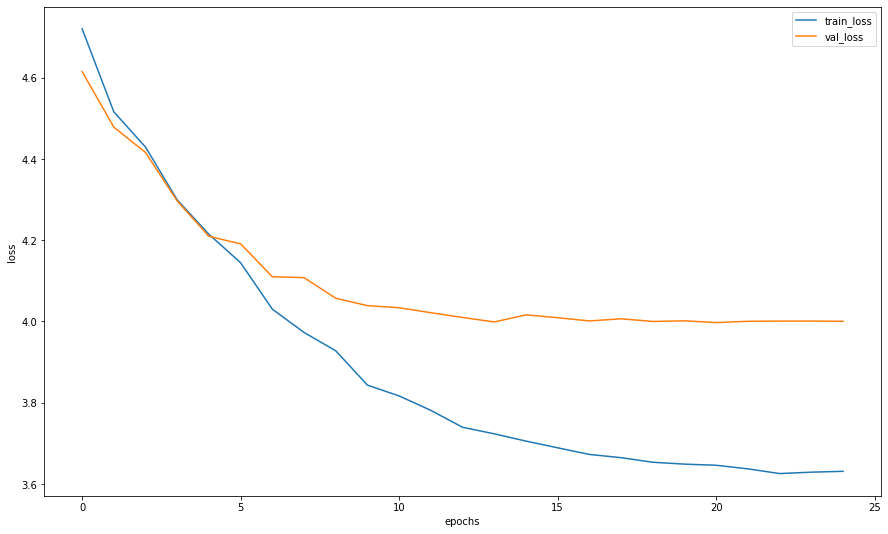

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
alex_dif_lr_1 = models.alexnet(pretrained=True)
num_features = 9216 #количество features поступающих на вход классифатору
alex_dif_lr_1.classifier = nn.Linear(num_features, n_classes)

optimizer = torch.optim.Adam(params=[{'params': alex_dif_lr.classifier.parameters()},
                                     {'params': alex_dif_lr.features.parameters(), 'lr': 1e-5}],
                             lr = 1e-4 )
criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
alex_dif_lr_1.to("cuda")

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Linear(in_features=9216, out_features=125, bias=True)
)

In [ ]:
history = train(train_dataset, val_dataset, model=alex_dif_lr_1, epochs=3, batch_size=64, scheduler=exp_lr_scheduler)

epoch:   0%|          | 0/3 [00:00<?, ?it/s]

loss 4.836354448893395


epoch:  33%|███▎      | 1/3 [02:41<05:22, 161.11s/it]


Epoch 001 train_loss: 4.8364   val_loss 4.8267 train_acc 0.0088 val_acc 0.0101
loss 4.826866556774152


epoch:  67%|██████▋   | 2/3 [05:18<02:38, 158.83s/it]


Epoch 002 train_loss: 4.8269   val_loss 4.8256 train_acc 0.0101 val_acc 0.0101
loss 4.82589943607273


epoch: 100%|██████████| 3/3 [07:54<00:00, 158.29s/it]


Epoch 003 train_loss: 4.8259   val_loss 4.8247 train_acc 0.0101 val_acc 0.0101


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)
val_acc = [val_acc[i].cpu().numpy() for i in range(len(val_acc))]

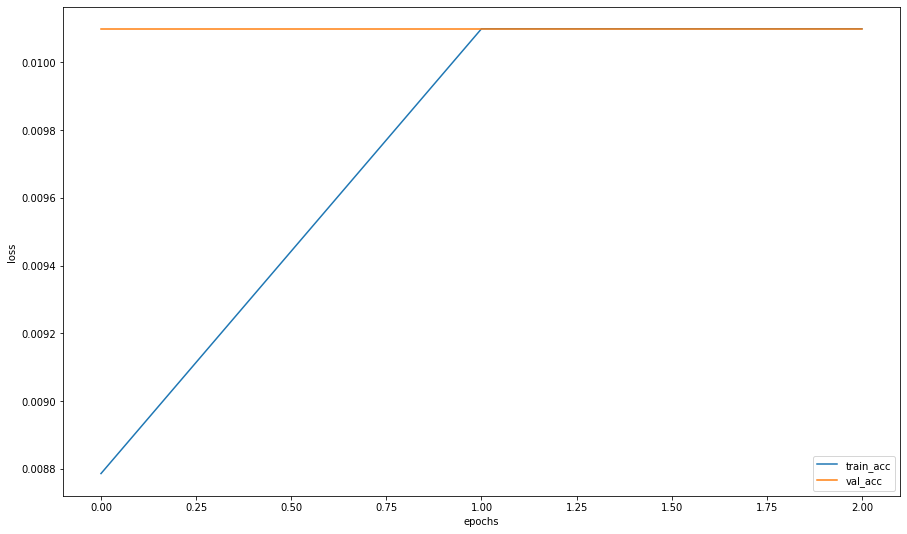

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

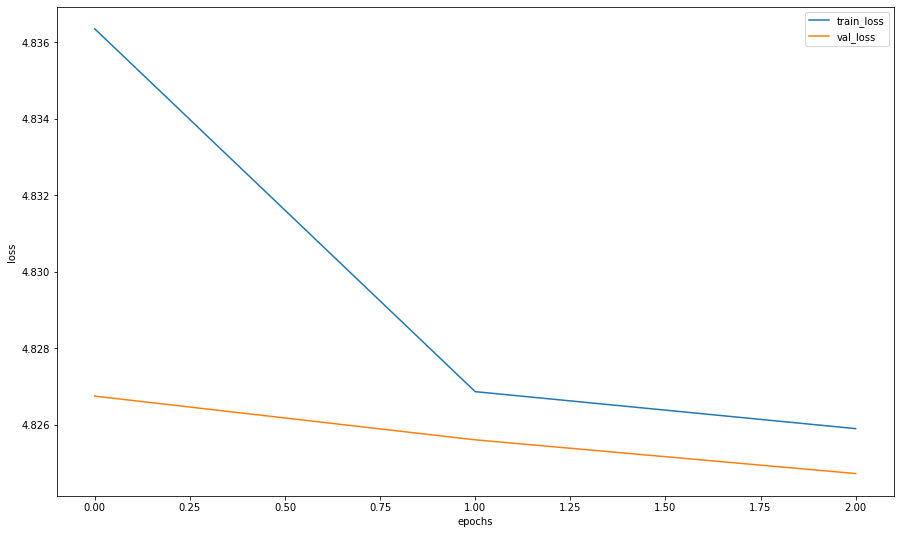

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# ResNet

In [ ]:
from torchvision import models
from torch.optim import lr_scheduler
resnet18 = models.resnet18(pretrained=False)
in_features = 512 #количество features поступающих на вход классифатору
resnet18.fc = nn.Linear(in_features, n_classes)

optimizer = torch.optim.Adam(resnet18.parameters(), lr = 1e-4)
criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
resnet18.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
history = train(train_dataset, val_dataset, model=resnet18, epochs=15, batch_size=64, scheduler=exp_lr_scheduler)

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

loss 4.646108715333946


epoch:   7%|▋         | 1/15 [03:01<42:21, 181.54s/it]


Epoch 001 train_loss: 4.6461   val_loss 4.5288 train_acc 0.0379 val_acc 0.0485
loss 4.521971481325434


epoch:  13%|█▎        | 2/15 [06:02<39:14, 181.13s/it]


Epoch 002 train_loss: 4.5220   val_loss 4.4195 train_acc 0.0404 val_acc 0.0478
loss 4.334939863286549


epoch:  20%|██        | 3/15 [09:02<36:08, 180.68s/it]


Epoch 003 train_loss: 4.3349   val_loss 4.3706 train_acc 0.0608 val_acc 0.0574
loss 4.134786475026771


epoch:  27%|██▋       | 4/15 [12:02<33:05, 180.49s/it]


Epoch 004 train_loss: 4.1348   val_loss 4.1240 train_acc 0.0829 val_acc 0.0882
loss 4.032835215082974


epoch:  33%|███▎      | 5/15 [15:03<30:07, 180.76s/it]


Epoch 005 train_loss: 4.0328   val_loss 4.1038 train_acc 0.1013 val_acc 0.0889
loss 3.933888821367345


epoch:  40%|████      | 6/15 [18:04<27:06, 180.67s/it]


Epoch 006 train_loss: 3.9339   val_loss 3.9980 train_acc 0.1178 val_acc 0.1091
loss 3.765539076304982


epoch:  47%|████▋     | 7/15 [21:04<24:02, 180.34s/it]


Epoch 007 train_loss: 3.7655   val_loss 3.9145 train_acc 0.1471 val_acc 0.1217
loss 3.6881755022435305


epoch:  53%|█████▎    | 8/15 [24:05<21:04, 180.65s/it]


Epoch 008 train_loss: 3.6882   val_loss 3.8488 train_acc 0.1512 val_acc 0.1313
loss 3.6114893630666973


epoch:  60%|██████    | 9/15 [27:04<18:01, 180.20s/it]


Epoch 009 train_loss: 3.6115   val_loss 3.8086 train_acc 0.1659 val_acc 0.1384
loss 3.470608288298805


epoch:  67%|██████▋   | 10/15 [30:05<15:01, 180.29s/it]


Epoch 010 train_loss: 3.4706   val_loss 3.7902 train_acc 0.1865 val_acc 0.1483
loss 3.401814281730016


epoch:  73%|███████▎  | 11/15 [33:05<12:01, 180.30s/it]


Epoch 011 train_loss: 3.4018   val_loss 3.7726 train_acc 0.1954 val_acc 0.1505
loss 3.342662191163907


epoch:  80%|████████  | 12/15 [36:05<09:00, 180.14s/it]


Epoch 012 train_loss: 3.3427   val_loss 3.7282 train_acc 0.2106 val_acc 0.1584
loss 3.235935398467177


epoch:  87%|████████▋ | 13/15 [39:03<05:59, 179.61s/it]


Epoch 013 train_loss: 3.2359   val_loss 3.6908 train_acc 0.2283 val_acc 0.1687
loss 3.1793057047603304


epoch:  93%|█████████▎| 14/15 [42:04<02:59, 179.94s/it]


Epoch 014 train_loss: 3.1793   val_loss 3.6803 train_acc 0.2406 val_acc 0.1712
loss 3.1384174958249504


epoch: 100%|██████████| 15/15 [45:04<00:00, 180.29s/it]


Epoch 015 train_loss: 3.1384   val_loss 3.6684 train_acc 0.2463 val_acc 0.1744


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)
val_acc = [val_acc[i].cpu().numpy() for i in range(len(val_acc))]

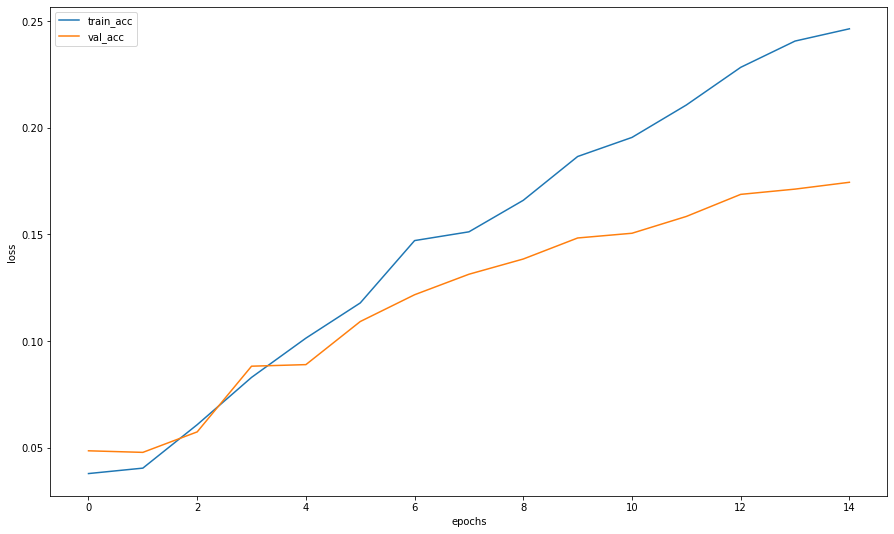

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

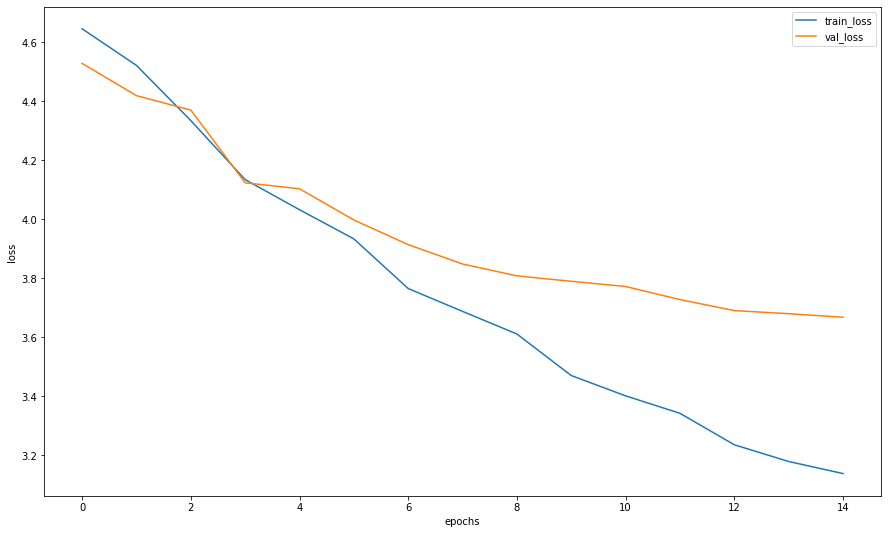

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# ResNet(pretrained=True)

In [ ]:
resnet18_tl = models.resnet18(pretrained=True)
in_features = 512 #количество features поступающих на вход классифатору
resnet18_tl.fc = nn.Sequential(
    nn.Linear(in_features, 256),
    nn.ReLU(),
    nn.Linear(256, n_classes)
    )

optimizer = torch.optim.Adam(resnet18_tl.parameters(), lr = 1e-4)
criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=1)

In [ ]:
resnet18_tl.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
history = train(train_dataset, val_dataset, model=resnet18_tl, epochs=5, batch_size=64, scheduler=exp_lr_scheduler)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 4.057242027262042


epoch:  20%|██        | 1/5 [03:07<12:30, 187.53s/it]


Epoch 001 train_loss: 4.0572   val_loss 4.0077 train_acc 0.0903 val_acc 0.1054
loss 4.810917595942352


epoch:  40%|████      | 2/5 [06:10<09:13, 184.55s/it]


Epoch 002 train_loss: 4.8109   val_loss 4.7091 train_acc 0.0142 val_acc 0.0214
loss 4.651688655693843


epoch:  60%|██████    | 3/5 [09:14<06:08, 184.42s/it]


Epoch 003 train_loss: 4.6517   val_loss 4.6006 train_acc 0.0230 val_acc 0.0261
loss 4.514870159143845


epoch:  80%|████████  | 4/5 [12:16<03:03, 183.74s/it]


Epoch 004 train_loss: 4.5149   val_loss 4.4586 train_acc 0.0379 val_acc 0.0470
loss 4.370701396295967


epoch: 100%|██████████| 5/5 [15:22<00:00, 184.59s/it]


Epoch 005 train_loss: 4.3707   val_loss 4.3050 train_acc 0.0507 val_acc 0.0562


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)
val_acc = [val_acc[i].cpu().numpy() for i in range(len(val_acc))]

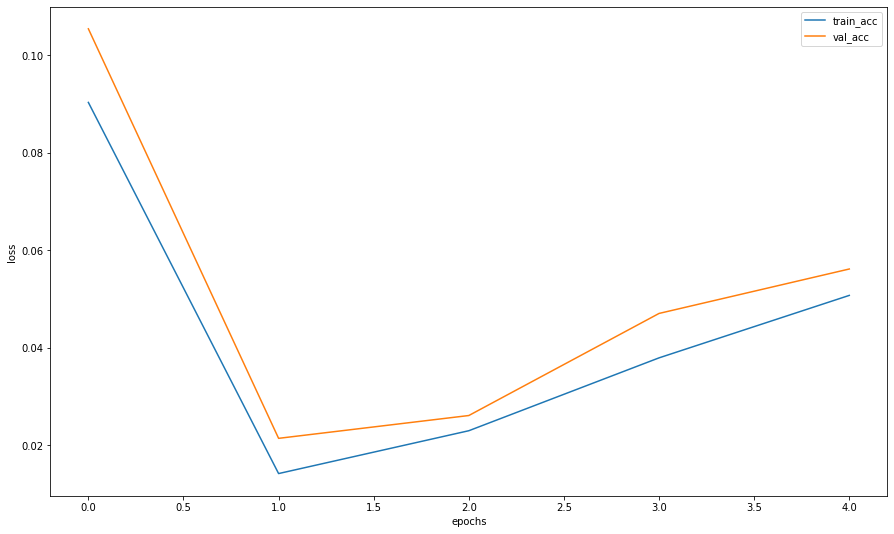

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

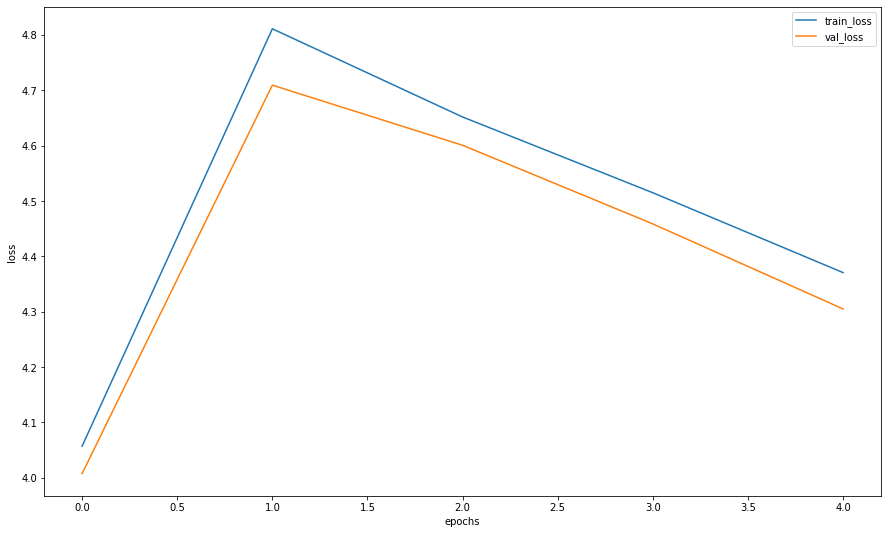

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# ResNet18 transfer learning

In [ ]:
model_conv = models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, n_classes)

model_conv = model_conv.to(DEVICE)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
history = train(train_dataset, val_dataset, model=model_conv, epochs=5, batch_size=64, scheduler=exp_lr_scheduler)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 3.9058601805920845


epoch:  20%|██        | 1/5 [02:25<09:40, 145.24s/it]


Epoch 001 train_loss: 3.9059   val_loss 3.0178 train_acc 0.1768 val_acc 0.3384
loss 2.66348273239853


epoch:  40%|████      | 2/5 [04:40<06:58, 139.56s/it]


Epoch 002 train_loss: 2.6635   val_loss 2.4831 train_acc 0.4130 val_acc 0.4214
loss 2.259453900469789


epoch:  60%|██████    | 3/5 [06:55<04:34, 137.35s/it]


Epoch 003 train_loss: 2.2595   val_loss 2.2946 train_acc 0.4752 val_acc 0.4468
loss 2.017752988339058


epoch:  80%|████████  | 4/5 [09:09<02:16, 136.12s/it]


Epoch 004 train_loss: 2.0178   val_loss 2.1932 train_acc 0.5226 val_acc 0.4677
loss 1.9327873542729892


epoch: 100%|██████████| 5/5 [11:21<00:00, 136.38s/it]


Epoch 005 train_loss: 1.9328   val_loss 2.1599 train_acc 0.5381 val_acc 0.4729


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)
val_acc = [val_acc[i].cpu().numpy() for i in range(len(val_acc))]

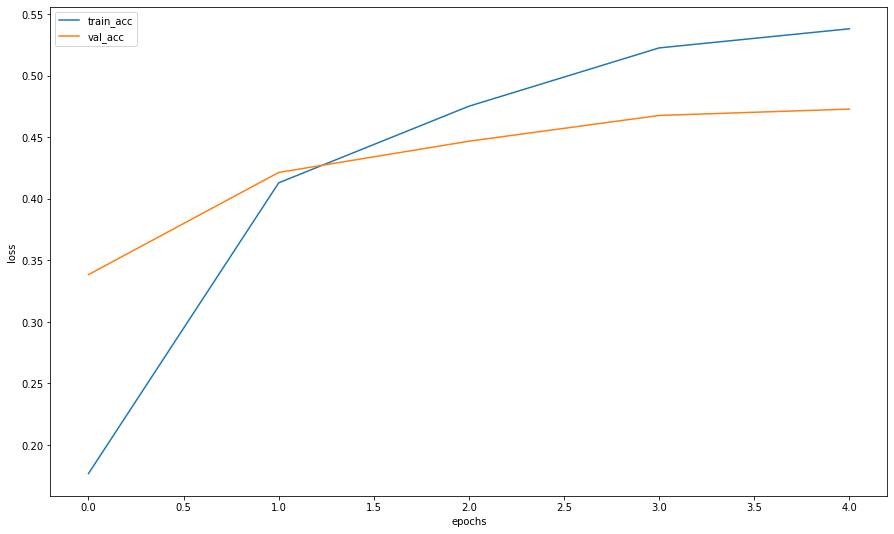

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

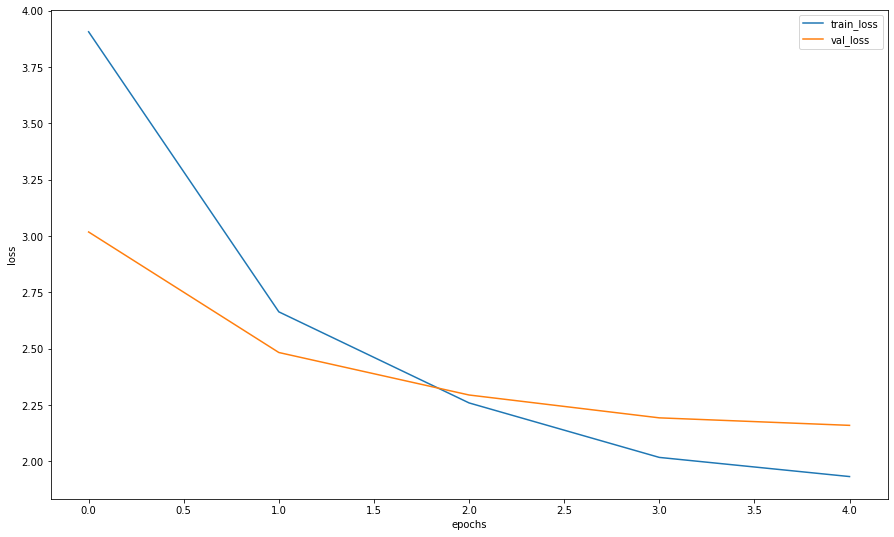

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# ResNeXT transfer learning

In [ ]:
resnext50 = models.resnext50_32x4d(pretrained=True)
for param in resnext50.parameters():
    param.requires_grad = False

num_ftrs = resnext50.fc.in_features
resnext50.fc = nn.Linear(num_ftrs, n_classes)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(resnext50.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
resnext50.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [ ]:
history = train(train_dataset, val_dataset, model=resnext50, epochs=20, batch_size=64, scheduler=exp_lr_scheduler)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 3.5416638849403914


epoch:   5%|▌         | 1/20 [04:19<1:22:03, 259.14s/it]


Epoch 001 train_loss: 3.5417   val_loss 2.4826 train_acc 0.2474 val_acc 0.4515
loss 2.2139817654318152


epoch:  10%|█         | 2/20 [08:30<1:16:20, 254.45s/it]


Epoch 002 train_loss: 2.2140   val_loss 2.1028 train_acc 0.4847 val_acc 0.4909


epoch:  15%|█▌        | 3/20 [12:40<1:11:36, 252.72s/it]


Epoch 003 train_loss: 1.8998   val_loss 2.0487 train_acc 0.5348 val_acc 0.5025
loss 1.634091840225719


epoch:  20%|██        | 4/20 [16:50<1:07:05, 251.58s/it]


Epoch 004 train_loss: 1.6341   val_loss 1.9090 train_acc 0.5986 val_acc 0.5298
loss 1.5825645834444897


epoch:  25%|██▌       | 5/20 [20:58<1:02:35, 250.34s/it]


Epoch 005 train_loss: 1.5826   val_loss 1.8770 train_acc 0.6089 val_acc 0.5429


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)
val_acc = [val_acc[i].cpu().numpy() for i in range(len(val_acc))]

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# ResNeXt (pretrained=False)

In [33]:
resnext50_2 = models.resnext50_32x4d(pretrained=False)
#for param in resnext50.parameters():
    #param.requires_grad = False

num_ftrs = resnext50_2.fc.in_features
resnext50_2.fc = nn.Linear(num_ftrs, n_classes)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(resnext50_2.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [34]:
resnext50_2.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [36]:
history = train(train_dataset, val_dataset, model=resnext50_2, epochs=10, batch_size=64, scheduler=exp_lr_scheduler)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 4.603649364217414


epoch:  10%|█         | 1/10 [08:26<1:16:02, 506.89s/it]


Epoch 001 train_loss: 4.6036   val_loss 4.4125 train_acc 0.0360 val_acc 0.0505
loss 4.360952851454978


epoch:  20%|██        | 2/10 [16:52<1:07:31, 506.39s/it]


Epoch 002 train_loss: 4.3610   val_loss 4.2250 train_acc 0.0587 val_acc 0.0719
loss 4.177381643844518


epoch:  30%|███       | 3/10 [25:19<59:05, 506.44s/it]


Epoch 003 train_loss: 4.1774   val_loss 4.0993 train_acc 0.0805 val_acc 0.0938
loss 3.906841226160081


epoch:  40%|████      | 4/10 [33:46<50:40, 506.74s/it]


Epoch 004 train_loss: 3.9068   val_loss 3.9581 train_acc 0.1224 val_acc 0.1158
loss 3.738589526651841


epoch:  50%|█████     | 5/10 [42:12<42:11, 506.30s/it]


Epoch 005 train_loss: 3.7386   val_loss 3.8478 train_acc 0.1430 val_acc 0.1340
loss 3.565766610381971


epoch:  60%|██████    | 6/10 [50:36<33:42, 505.60s/it]


Epoch 006 train_loss: 3.5658   val_loss 3.7282 train_acc 0.1722 val_acc 0.1589
loss 3.2620534300363673


epoch:  70%|███████   | 7/10 [59:02<25:17, 505.71s/it]


Epoch 007 train_loss: 3.2621   val_loss 3.6262 train_acc 0.2274 val_acc 0.1842
loss 3.0508948362796646


epoch:  80%|████████  | 8/10 [1:07:29<16:52, 506.17s/it]


Epoch 008 train_loss: 3.0509   val_loss 3.7024 train_acc 0.2610 val_acc 0.1805
loss 2.8545060143876775


epoch:  90%|█████████ | 9/10 [1:15:56<08:26, 506.33s/it]


Epoch 009 train_loss: 2.8545   val_loss 3.6881 train_acc 0.2955 val_acc 0.1869
loss 2.4664524097005684


epoch: 100%|██████████| 10/10 [1:24:23<00:00, 506.34s/it]


Epoch 010 train_loss: 2.4665   val_loss 3.8726 train_acc 0.3788 val_acc 0.1852


In [38]:
loss, acc, val_loss, val_acc = zip(*history)
val_acc = [val_acc[i].cpu().numpy() for i in range(len(val_acc))]

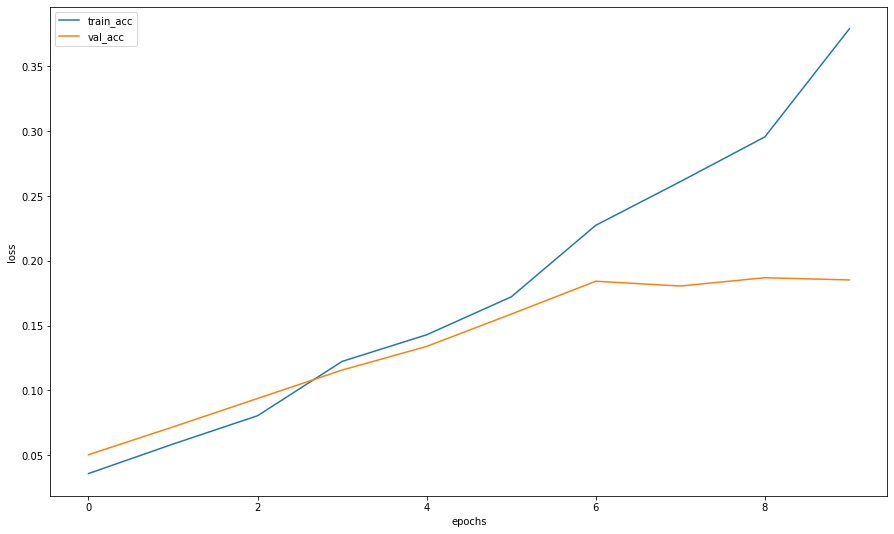

In [39]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

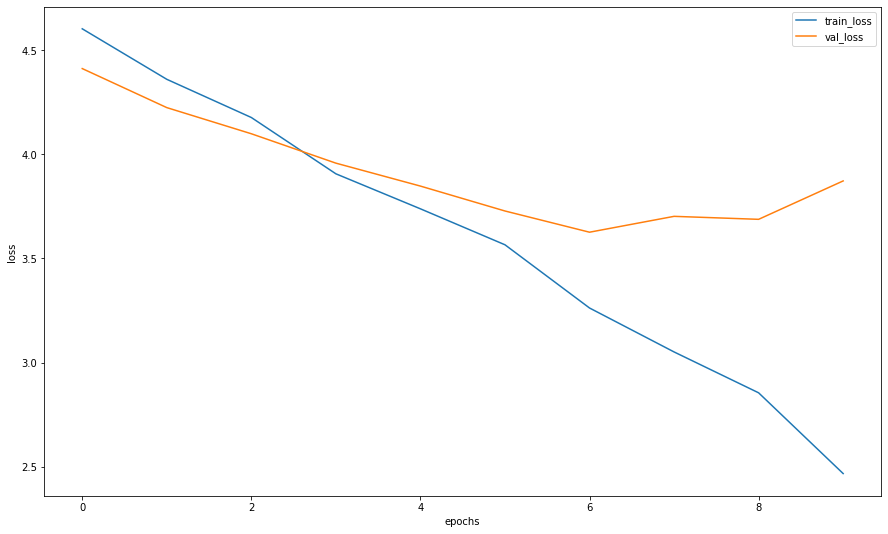

In [40]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [37]:
test_dataset = CVDataSet(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=40)
probs = predict(resnext50_2.to(DEVICE), test_loader)
test_filenames = [path.name for path in test_dataset.files]
preds = np.argmax(probs, axis=1)

df = pd.DataFrame()
df['image'] = test_filenames
df['label'] = preds
df.to_csv('gdrive/My Drive/cv2022spring_5.csv', index=False)